In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('fifa_players_reduced.csv')

In [26]:
df

,id,name,age,nation,height,league,team,position,alternative_positions,ovr
0,0,Kylian Mbappé,25,France,"182cm / 6'0""",La Liga,Real Madrid,ST,LW,91
1,1,Rodri,28,Spain,"191cm / 6'3""",Premier League,Manchester City,CDM,CM,91
2,2,Erling Haaland,24,Norway,"195cm / 6'5""",Premier League,Manchester City,ST,NaN,91
3,3,Jude Bellingham,21,England,"186cm / 6'1""",La Liga,Real Madrid,CAM,CM,90
4,4,Vini Jr.,24,Brazil,"176cm / 5'9""",La Liga,Real Madrid,LW,"ST, LM",90
...,...,...,...,...,...,...,...,...,...,...
348,348,Callum Wilson,32,England,"180cm / 5'11""",Premier League,Newcastle Utd,ST,NaN,81
349,349,Lamine Yamal,17,Spain,"180cm / 5'11""",La Liga,FC Barcelona,RW,"LW, RM",81
350,350,Wilfried Zaha,31,Côte d'Ivoire,"180cm / 5'11""",Ligue 1 McDonald's,OL,LM,LW,81
351,351,Piotr Zieliński,30,Poland,"180cm / 5'11""",Serie A Enilive,Lombardia FC,CM,CDM,81


In [27]:
import pandas as pd
import requests
import base64
import io
from PIL import Image
from io import BytesIO
import time
import os
import urllib.parse

def get_player_image_from_wikipedia(player_name):
    """
    Get soccer player image using Wikipedia API with proper User-Agent
    
    Args:
        player_name (str): The name of the soccer player
        
    Returns:
        str: URL of the player's image if found, None otherwise
    """
    # Set proper User-Agent header to comply with Wikimedia policy
    headers = {
        "User-Agent": "PlayerImageScraper/1.0 (personal research project; your.email@example.com)"
    }
    
    # First search for the player's Wikipedia page
    search_url = "https://en.wikipedia.org/w/api.php"
    search_params = {
        "action": "query",
        "format": "json",
        "list": "search",
        "srsearch": f"{player_name} footballer",
        "srlimit": 1
    }
    
    try:
        search_response = requests.get(search_url, params=search_params, headers=headers)
        search_response.raise_for_status()
        search_data = search_response.json()
        
        if "query" in search_data and "search" in search_data["query"] and len(search_data["query"]["search"]) > 0:
            # Get the page title
            page_title = search_data["query"]["search"][0]["title"]
            
            # Now get the page images
            image_url = "https://en.wikipedia.org/w/api.php"
            image_params = {
                "action": "query",
                "format": "json",
                "titles": page_title,
                "prop": "pageimages",
                "pithumbsize": 500  # Image size
            }
            
            image_response = requests.get(image_url, params=image_params, headers=headers)
            image_response.raise_for_status()
            image_data = image_response.json()
            
            # Extract the image URL
            pages = image_data["query"]["pages"]
            for page_id in pages:
                if "thumbnail" in pages[page_id] and "source" in pages[page_id]["thumbnail"]:
                    return pages[page_id]["thumbnail"]["source"], headers
    
    except Exception as e:
        print(f"Error fetching image for {player_name} from Wikipedia: {e}")
    
    return None, None

def get_player_image_from_thesportsdb(player_name):
    """
    Get soccer player image using TheSportsDB API (free tier)
    
    Args:
        player_name (str): The name of the soccer player
        
    Returns:
        str: URL of the player's image if found, None otherwise
    """
    # Standard headers for regular web requests
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    # API endpoint for player search
    url = f"https://www.thesportsdb.com/api/v1/json/3/searchplayers.php?p={player_name}"
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        if "player" in data and data["player"]:
            for player in data["player"]:
                # Check if this is a soccer/football player
                if player.get("strSport") == "Soccer":
                    # Get the player's image
                    thumb_url = player.get("strThumb")
                    cut_out_url = player.get("strCutout")
                    render_url = player.get("strRender")
                    
                    # Return the first available image (prefer cutout if available)
                    if cut_out_url:
                        return cut_out_url, headers
                    elif thumb_url:
                        return thumb_url, headers
                    elif render_url:
                        return render_url, headers
    
    except Exception as e:
        print(f"Error fetching image for {player_name} from TheSportsDB: {e}")
    
    return None, None

def search_player_image(player_name):
    """
    Search for a soccer player's image using Google search
    
    Args:
        player_name (str): The name of the soccer player
        
    Returns:
        str: URL of the player's image if found, None otherwise
    """
    # Format the search query
    search_query = f"{player_name} soccer player official"
    encoded_query = urllib.parse.quote(search_query)
    
    # Create Google Images search URL
    url = f"https://www.google.com/search?q={encoded_query}&tbm=isch"
    
    # Set a user agent to mimic a browser
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    try:
        # Send the request
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # Parse the HTML to find image URLs
        image_urls = []
        content = response.text
        
        # Look for image URLs in the HTML
        start_marker = "src=\"https://"
        end_marker = "\""
        
        start_idx = 0
        while True:
            start_idx = content.find(start_marker, start_idx)
            if start_idx == -1:
                break
                
            start_idx += 5  # Move past 'src="'
            end_idx = content.find(end_marker, start_idx)
            
            if end_idx != -1:
                img_url = content[start_idx:end_idx]
                if "http" in img_url and not img_url.endswith(".gif") and not "gstatic.com" in img_url:
                    image_urls.append(img_url)
                    
                start_idx = end_idx
                
                # If we have found enough images, break
                if len(image_urls) >= 5:
                    break
        
        # Return the first valid image URL (if any were found)
        for url in image_urls:
            try:
                # Test if the URL is valid and is an image
                img_response = requests.head(url, headers=headers, timeout=5)
                content_type = img_response.headers.get('Content-Type', '')
                
                if 'image' in content_type:
                    return url, headers
            except:
                continue
                
    except Exception as e:
        print(f"Error searching for {player_name}: {e}")
    
    return None, None

def get_player_image(player_name):
    """
    Try multiple sources to get a player image
    Returns the image as a PIL Image object or None if not found
    """
    # Try Wikipedia first (most reliable free source)
    img_url, headers = get_player_image_from_wikipedia(player_name)
    source = "Wikipedia" if img_url else None
    
    # Fall back to TheSportsDB if Wikipedia fails
    if not img_url:
        img_url, headers = get_player_image_from_thesportsdb(player_name)
        source = "TheSportsDB" if img_url else None
    
    # Last resort: Google search
    if not img_url:
        img_url, headers = search_player_image(player_name)
        source = "Google" if img_url else None
    
    if img_url and headers:
        try:
            # Use the proper headers when downloading
            print(f"Attempting to download from {source}: {img_url}")
            response = requests.get(img_url, timeout=10, headers=headers)
            response.raise_for_status()
            
            # Log success
            print(f"Successfully downloaded image from {source}")
            return Image.open(BytesIO(response.content))
            
        except Exception as e:
            print(f"Error downloading image for {player_name}: {e}")
            print(f"Failed URL: {img_url}")
    
    return None

def image_to_base64(image, format="JPEG", max_size=(150, 150)):
    """
    Convert a PIL Image to a base64 encoded string with optional resizing
    """
    # Resize image to reduce size if needed
    if max_size:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)
    
    # Convert to base64
    buffer = BytesIO()
    image.save(buffer, format=format)
    img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
    
    return f"data:image/{format.lower()};base64,{img_str}"

def add_player_images_to_dataframe(df, name_column='name'):
    """
    Add a new 'image' column to the dataframe with base64 encoded player images
    
    Args:
        df (DataFrame): The pandas DataFrame containing player data
        name_column (str): The column name containing player names
        
    Returns:
        DataFrame: The updated DataFrame with an 'image' column
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    # Add an empty 'image' column
    result_df['image'] = None
    
    # Process each player
    for index, row in result_df.iterrows():
        player_name = row[name_column]
        print(f"Processing {player_name} ({index+1}/{len(df)})...")
        
        # Get the player image
        img = get_player_image(player_name)
        
        if img:
            # Convert to base64 and add to DataFrame
            try:
                base64_img = image_to_base64(img)
                result_df.at[index, 'image'] = base64_img
                print(f"✓ Added image for {player_name}")
            except Exception as e:
                print(f"✗ Error encoding image for {player_name}: {e}")
        else:
            print(f"✗ No image found for {player_name}")
        
        # Add a small delay to be nice to the APIs
        time.sleep(1)
    
    # Stats on success
    image_count = result_df['image'].count()
    print(f"Added images for {image_count} out of {len(df)} players ({image_count/len(df)*100:.1f}%)")
    
    return result_df

In [28]:
# Add player images to the DataFrame
df_with_images = add_player_images_to_dataframe(df)  

Processing Kylian Mbappé (1/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Mbappe_before_Real_Madrid_vs_Alaves_3_-_2_Matchday_7_La_Liga_2024_%28cropped%29.jpg/500px-Mbappe_before_Real_Madrid_vs_Alaves_3_-_2_Matchday_7_La_Liga_2024_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Kylian Mbappé
Processing Rodri (2/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/RODRI_-_SWE_vs_ESP_-_UEFA_EURO_2020_QUALIFIERS_-_2019.10.15_%28cropped%29.jpg/500px-RODRI_-_SWE_vs_ESP_-_UEFA_EURO_2020_QUALIFIERS_-_2019.10.15_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Rodri
Processing Erling Haaland (3/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/5/57/ManCity20240722-031_%28cropped%29.jpg/500px-ManCity20240722-031_%28cropped%29.jpg
Successfully downloaded image from Wikipedia

Successfully downloaded image from Wikipedia
✓ Added image for Florian Wirtz
Processing Gregor Kobel (27/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/2023-08-12_TSV_Schott_Mainz_gegen_Borussia_Dortmund_%28DFB-Pokal_2023-24%29_by_Sandro_Halank%E2%80%93090.jpg/500px-2023-08-12_TSV_Schott_Mainz_gegen_Borussia_Dortmund_%28DFB-Pokal_2023-24%29_by_Sandro_Halank%E2%80%93090.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Gregor Kobel
Processing William Saliba (28/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Lens_-_Marseille_%2822-01-2022%29_15.jpg/500px-Lens_-_Marseille_%2822-01-2022%29_15.jpg
Successfully downloaded image from Wikipedia
✓ Added image for William Saliba
Processing Victor Osimhen (29/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/0K8A7984_%2853451306826%29_%28cropped%29.jpg/500px-0K8

Successfully downloaded image from Wikipedia
✓ Added image for Grimaldo
Processing Luka Modrić (53/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Luka_Modric_Interview_2021_%28cropped%29.jpg/500px-Luka_Modric_Interview_2021_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Luka Modrić
Processing Alexis Mac Allister (54/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Alexis_Mac_Allister_WC_2022.jpg/500px-Alexis_Mac_Allister_WC_2022.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Alexis Mac Allister
Processing Carvajal (55/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/UEFA_EURO_qualifiers_Sweden_vs_Spain_20191015_Dani_Carvajal_10_%28cropped%29.jpg/500px-UEFA_EURO_qualifiers_Sweden_vs_Spain_20191015_Dani_Carvajal_10_%28cropped%29.jpg
Successfully downloaded image from 

Processing Mikel Merino (79/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Miker_Merino_2018_%28cropped%29.jpg/500px-Miker_Merino_2018_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Mikel Merino
Processing Sergej Milinković-Savić (80/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/a/a2/Milinkovi%C4%87-Savi%C4%87_2018.jpg/500px-Milinkovi%C4%87-Savi%C4%87_2018.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Sergej Milinković-Savić
Processing Loïs Openda (81/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Lens_-_Reims_%2812-05-2023%29_32_%28cropped%29.jpg/500px-Lens_-_Reims_%2812-05-2023%29_32_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Loïs Openda
Processing Palhinha (82/353)...
Attempting to download from Wikipedia: https://upload.wik

Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/c/c0/Luis_D%C3%ADaz_%28portrait%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Luis Díaz
Processing Federico Dimarco (106/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/FC_Salzburg_gegen_Inter_Mailand_%28Testspiel_2023-08-09%29_73_-_Federico_Dimarco_%28cropped%29.jpg/500px-FC_Salzburg_gegen_Inter_Mailand_%28Testspiel_2023-08-09%29_73_-_Federico_Dimarco_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Federico Dimarco
Processing Artem Dovbyk (107/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/3/36/Artem_Dovbyk.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Artem Dovbyk
Processing Jeremie Frimpong (108/353)...
Attempting to download from TheSportsDB: https://www.thesportsdb.com/images/media/player/cutout/qk4vp71741769381.png
S

Processing Robert Andrich (133/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Robert_Andrich%2C_2022-07-31%2C_Saisoner%C3%B6ffnung_Bayer_04%2C_Leverkusen_%281%29_%28cropped%29.jpg/500px-Robert_Andrich%2C_2022-07-31%2C_Saisoner%C3%B6ffnung_Bayer_04%2C_Leverkusen_%281%29_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Robert Andrich
Processing Ismaël Bennacer (134/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/2/2c/BennacerLeB2022.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Ismaël Bennacer
Processing Domenico Berardi (135/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/c/c8/Domenico_Berardi%2C_Palazzo_Chigi%2C_2021.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Domenico Berardi
Processing Eduardo Camavinga (136/353)...
Attempting to download from Wikipedia: https:/

Processing Robin Le Normand (158/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/9/9d/Robin_Le_Normand_2122.jpg/500px-Robin_Le_Normand_2122.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Robin Le Normand
Processing Marcos Llorente (159/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Marcos_Llorente_2019.jpg/500px-Marcos_Llorente_2019.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Marcos Llorente
Processing Manuel Locatelli (160/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/FC_Zenit_Saint_Petersburg_vs._Juventus%2C_20_October_2021_34_%28Manuel_Locatelli%29.jpg/500px-FC_Zenit_Saint_Petersburg_vs._Juventus%2C_20_October_2021_34_%28Manuel_Locatelli%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Manuel Locatelli
Processing Donyell Malen (161/353)...
Attempting to 

Successfully downloaded image from Wikipedia
✓ Added image for Edmond Tapsoba
Processing Nuno Mendes (185/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/FC_Salzburg_gegen_Paris_Saint-Germain_UEFA_Champions_League_85.jpg/500px-FC_Salzburg_gegen_Paris_Saint-Germain_UEFA_Champions_League_85.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Nuno Mendes
Processing Marcus Thuram (186/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Marcus_Thuram_in_2023.jpg/500px-Marcus_Thuram_in_2023.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Marcus Thuram
Processing Fikayo Tomori (187/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/FC_Salzburg_vs._AC_Mailand_%28UEFA_Championsleague_2022-09-06%29_42.jpg/500px-FC_Salzburg_vs._AC_Mailand_%28UEFA_Championsleague_2022-09-06%29_42.jpg
Successfully downlo

Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Diogo_Dalot_2022_%28cropped%29.jpg/500px-Diogo_Dalot_2022_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Diogo Dalot
Processing Sergi Darder (214/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/BHA_5_v_Espanyol_1_pre_season_30_07_2022_38_%28cropped%29.jpg/500px-BHA_5_v_Espanyol_1_pre_season_30_07_2022_38_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Sergi Darder
Processing Alphonso Davies (215/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Alphonso_Davies_in_2022.jpg/500px-Alphonso_Davies_in_2022.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Alphonso Davies
Processing Giovanni Di Lorenzo (216/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thum

Successfully downloaded image from Wikipedia
✓ Added image for Randal Kolo Muani
Processing Filip Kostić (241/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/2022128173937_2022-05-08_Fussball_Eintracht_Frankfurt_vs_Borussia_M%C3%B6nchengladbach_-_Sven_-_1D_X_MK_II_-_2399_-_B70I8510_%28Filip_Kosti%C4%87_cropped%29.jpg/500px-2022128173937_2022-05-08_Fussball_Eintracht_Frankfurt_vs_Borussia_M%C3%B6nchengladbach_-_Sven_-_1D_X_MK_II_-_2399_-_B70I8510_%28Filip_Kosti%C4%87_cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Filip Kostić
Processing Mohammed Kudus (242/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Mohammed_Kudus_of_West_Ham_United.jpeg/500px-Mohammed_Kudus_of_West_Ham_United.jpeg
Successfully downloaded image from Wikipedia
✓ Added image for Mohammed Kudus
Processing Dejan Kulusevski (243/353)...
Attempting to download from Wikipedia: htt

Successfully downloaded image from Wikipedia
✓ Added image for Patrik Schick
Processing Luke Shaw (267/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Luke_Shaw%2C_Manchester_United_v_Newcastle_United%2C_11_September_2021_%2844%29_%28cropped%29.jpg/500px-Luke_Shaw%2C_Manchester_United_v_Newcastle_United%2C_11_September_2021_%2844%29_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Luke Shaw
Processing Malcom (268/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Malcom_2020_Super_Cup.jpg/500px-Malcom_2020_Super_Cup.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Malcom
Processing Chris Smalling (269/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/CSKA-MU_2017_%2815%29.jpg/500px-CSKA-MU_2017_%2815%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Chri

Processing Jonathan David (294/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Jonathan_David_asse_losc_2425_%28cropped%29.jpg/500px-Jonathan_David_asse_losc_2425_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Jonathan David
Processing Richarlison (295/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/5/5b/07_07_2019_Final_da_Copa_Am%C3%A9rica_2019_%2848226557731%29_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Richarlison
Processing Luuk de Jong (296/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/8/85/Zenit-PSV_%286%29.jpg/500px-Zenit-PSV_%286%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Luuk de Jong
Processing Fred (297/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/8/8d/Fred_Brazil_%28cropped%

Successfully downloaded image from Wikipedia
✓ Added image for Brais Méndez
Processing Alex Meret (322/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/Alex_Meret_%28cropped%29.jpg/500px-Alex_Meret_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Alex Meret
Processing Arkadiusz Milik (323/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Lens_-_Marseille_%2803-02-2021%29_44.jpg/500px-Lens_-_Marseille_%2803-02-2021%29_44.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Arkadiusz Milik
Processing Kaoru Mitoma (324/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Kaoru_Mitoma_%282022%29.jpg/500px-Kaoru_Mitoma_%282022%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Kaoru Mitoma
Processing Fernando Muslera (325/353)...
Attempting to download from Wikipedia

Processing Lamine Yamal (350/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/8/8d/Lamine_Yamal%2C_S%C3%A1nchez_se_reuni%C3%B3_con_los_futbolistas_de_la_selecci%C3%B3n_espa%C3%B1ola_tras_ganar_la_Eurocopa_2024_%283%29_%28cropped%29.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Lamine Yamal
Processing Wilfried Zaha (351/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Wilfried_Zaha_17-12-2016_1.jpg/500px-Wilfried_Zaha_17-12-2016_1.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Wilfried Zaha
Processing Piotr Zieliński (352/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/f/f3/Piotr_Zieli%C5%84ski_2018.jpg
Successfully downloaded image from Wikipedia
✓ Added image for Piotr Zieliński
Processing Zubimendi (353/353)...
Attempting to download from Wikipedia: https://upload.wikimedia.org/wikipedia/commons/3/3

''
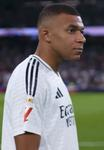

In [32]:
df_with_images.iloc[0]['image']

In [34]:
df_with_images.to_csv('reduced_with_images')